In [1]:
import msprime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pdb
from scipy.special import gammaln
import seaborn as sns
import mushi
import pickle
import os

In [4]:
plt.rcParams['figure.figsize'] = [24, 16] 
plt.rcParams.update({'font.size': 50})
# plt.plot([1,2,3],[1,2,3])

In [5]:
def simulate_model_SFS(pop_changes,time_points,num_replicates,num_individuals,verbosity=10000):
    # pop_changes, real size
    # time_points, units of generations
    # num_replicates, int
    human_indices = np.arange(0,num_individuals,1)

    SFS_simulated = np.zeros(num_individuals+1)
    for i in range(0,num_replicates):
        if i%verbosity==0:
            print(f'\ton rep={i}')
        demography = msprime.Demography()
        demography.add_population(name="human", initial_size=pop_changes[0])
        for i in range(1,len(pop_changes)):
            demography.add_population_parameters_change(time_points[i], initial_size=pop_changes[i], growth_rate=0, population="human") 
        demography.sort_events()
        # print(demography.debug())
        sim = msprime.sim_ancestry(samples={"human": num_individuals},ploidy=1,demography=demography,model="hudson")
        SFS_simulated+=sim.allele_frequency_spectrum(sample_sets=[human_indices],mode="branch",polarised=True)
    return SFS_simulated

def log_likelihood_poisson(observed,expected_norm):
    # observed is array of counts from data
    # expected_norm is a frequency array (floats) that sums to one; these are the expected proportions under some model
    expected = observed.sum()*expected_norm
    
    zis = observed.shape[0]
    zLL = 0
    for i in range(0,zis):
        z = observed[i]*np.log(expected[i]) - expected[i] - gammaln(observed[i])  
        zLL+=z
    return zLL


def compute_expected_sfs(sample_size, change_points, sizes): # Thanks to Yun Deng who wrote this function 
    eta = mushi.eta(change_points, sizes)
    L = mushi.utils.C(sample_size) @ mushi.utils.M(sample_size, *eta.arrays())
    esfs = L.sum(1)
    return esfs

def clean_time_column_from_FitCoal(times):
    for c,time in enumerate(times[0:-1]):
        if times[c+1]==times[c]:
            times[c+1]+=1
    return times


## Demography

I ran FitCoal and mushi on data with no polarisation. See http://localhost:3231/notebooks/falsifying_bottleneck/inference_FitCoal_241006.ipynb, http://localhost:3231/notebooks/falsifying_bottleneck/inference_mushi_241011.ipynb, /home/tc557/falsifying_bottleneck/searching_mushi_model_241011.sh, and FitCoal_Notes_240215.txt

truncate=20
trend_1=0; trend_2=1; ridge=1000
Succeeded for YRI truncate 20


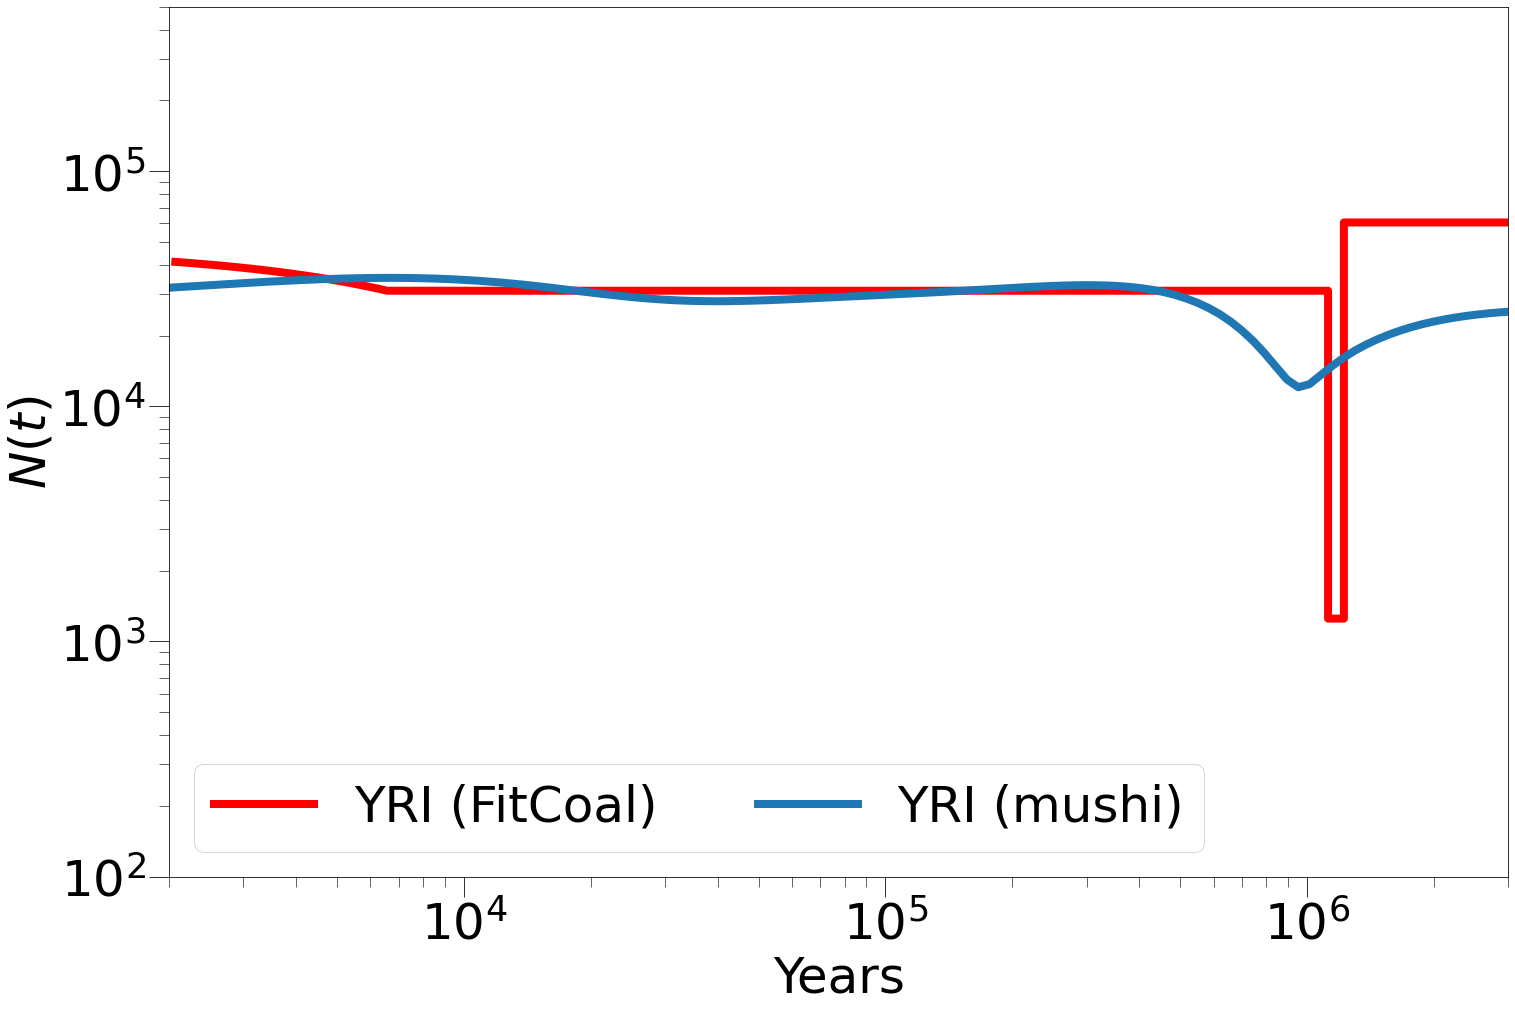

In [70]:
FitCoal_colors_pops = {'MSL':'red','ESN':'red','YRI':'red','CHB':'lightskyblue','JPT':'lightskyblue','BEB':'green','GBR':'gold','TSI':'gold','ITU':'gold'}

FitCoal_gen = 29 # the gen I used in FitCoal
mushi_gen = 30 # the gen I used in mushi
gen = 30 # the gen I use here

zlinewidth=8
trend_1s = [0]
trend_2s = [1]
ridges = [1000]

folded = 'False'

for trend_1 in trend_1s:
    for trend_2 in trend_2s:
        for ridge in ridges:
            for truncate in [20]:
                print(f'truncate={truncate}')
                print(f'trend_1={trend_1}; trend_2={trend_2}; ridge={ridge}')
                for zpop in ['YRI']:
                    
                    
                    # FitCoal
                    inferencefile = f'/home/tc557/FitCoal1dot0/inference1KGP_241011_mydata_nopolar_mappability_Bval0.8/truncate{truncate}_{zpop}.txt'
                    inference = np.loadtxt(inferencefile,skiprows=1)
                    plt.plot(gen*inference[:,0]/FitCoal_gen,inference[:,1],label=f'{zpop} (FitCoal)',linewidth=zlinewidth,color=FitCoal_colors_pops[zpop])
                    print(f'Succeeded for {zpop} truncate {truncate}')
                    del inference
                    
                    # mushi 
                    inferenceparameters_file = f'/home/tc557/rds/hpc-work/mushi_1KGP_inference_241011/{zpop}_{trend_1}_{trend_2}_{ridge}_{folded}model_parameters.pickle'
                    with open(inferenceparameters_file,'rb') as f:
                        inferenceparameters = pickle.load(f)
                    mushi_model = inferenceparameters['mushi_model']
                    plt.plot(gen*mushi_model[:,0]/mushi_gen,mushi_model[:,1],label=f'{zpop} (mushi)',linewidth=zlinewidth)
            plt.xlabel('Years')
            plt.ylabel('$N(t)$')
            plt.xscale('log')
            plt.yscale('log')

            plt.legend(loc="lower left",ncol=3)
            plt.tick_params(which='major',length=20)
            plt.tick_params(which='minor',length=10)
#             plt.title(f'Truncate {truncate}')
            plt.ylim(1e+2,5e+05)
            plt.xlim(2e+03,3e+06)
            plt.savefig(f'/home/tc557/falsifying_bottleneck/Figures_241008/paperFigure_FitCoaltruncate{truncate}_mushi{trend_1}_{trend_2}_{ridge}_YRI_241014_1900.pdf')
            plt.show()

## SFS Fits 

trend_1=0; trend_2=1; ridge=1000; truncate=20


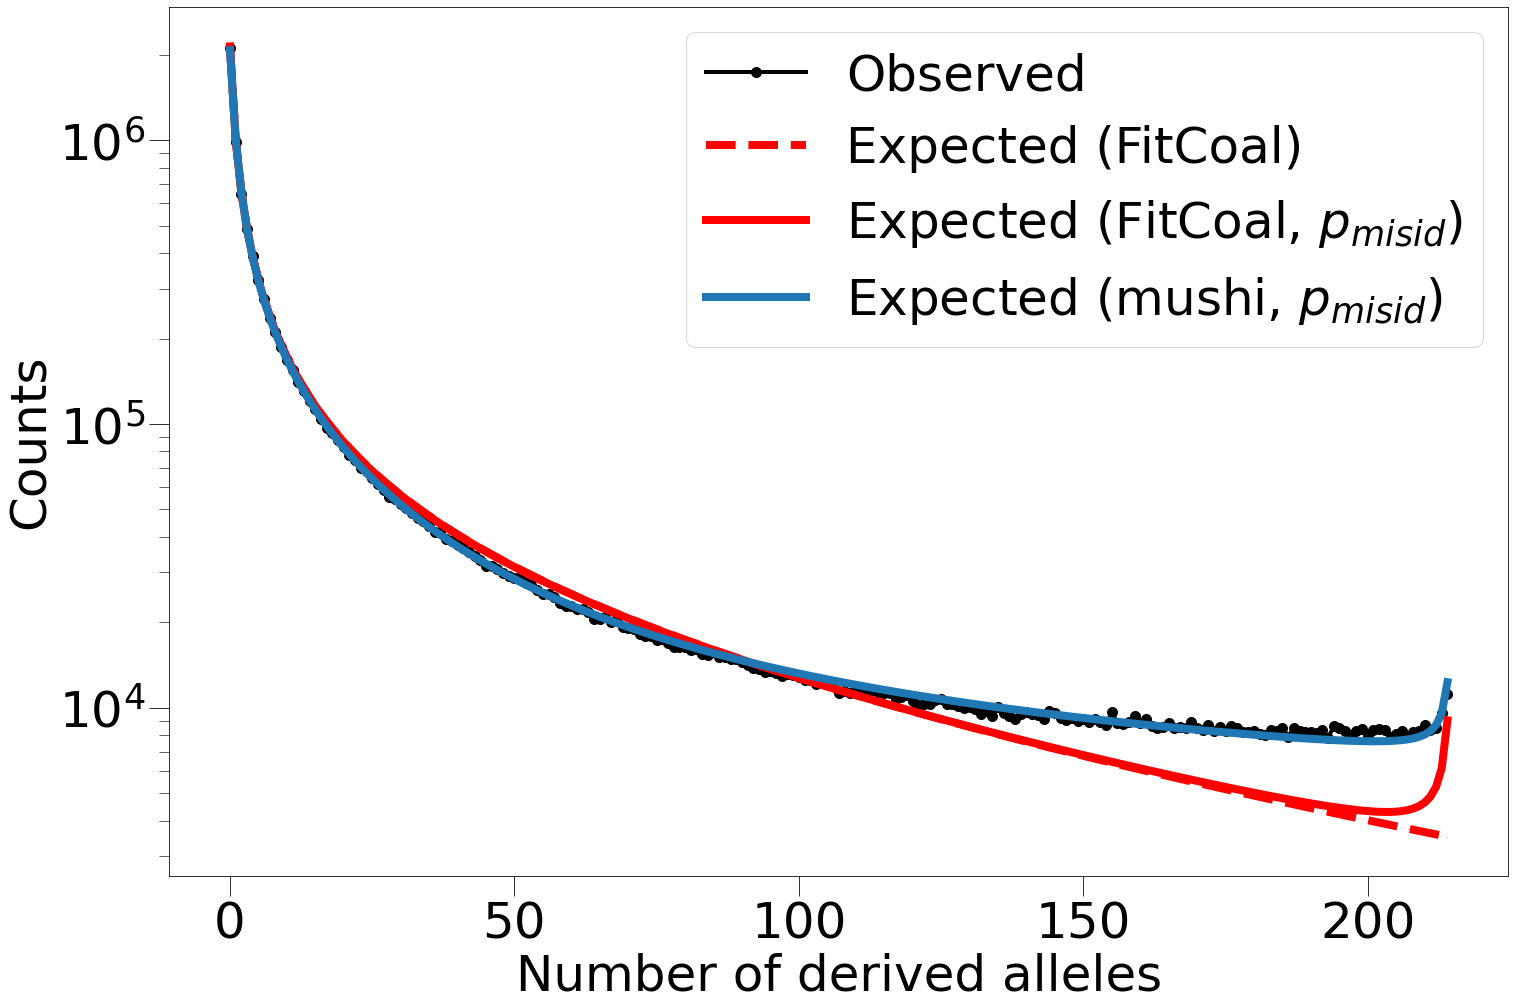

inferred p from mushi = 0.002570218954376807
FitCoal LL (without p_misid) -92936.9867075761
FitCoal LL (with p_misid) -71406.77875781387
mushi LL (with p_misid) = -1503.3365711546212
LL(mushi) - LL(FitCoal) (with p_misid in FitCoal) = 69903.44218665925
LL(mushi) - LL(FitCoal) (without p_misid)= 91433.65013642148





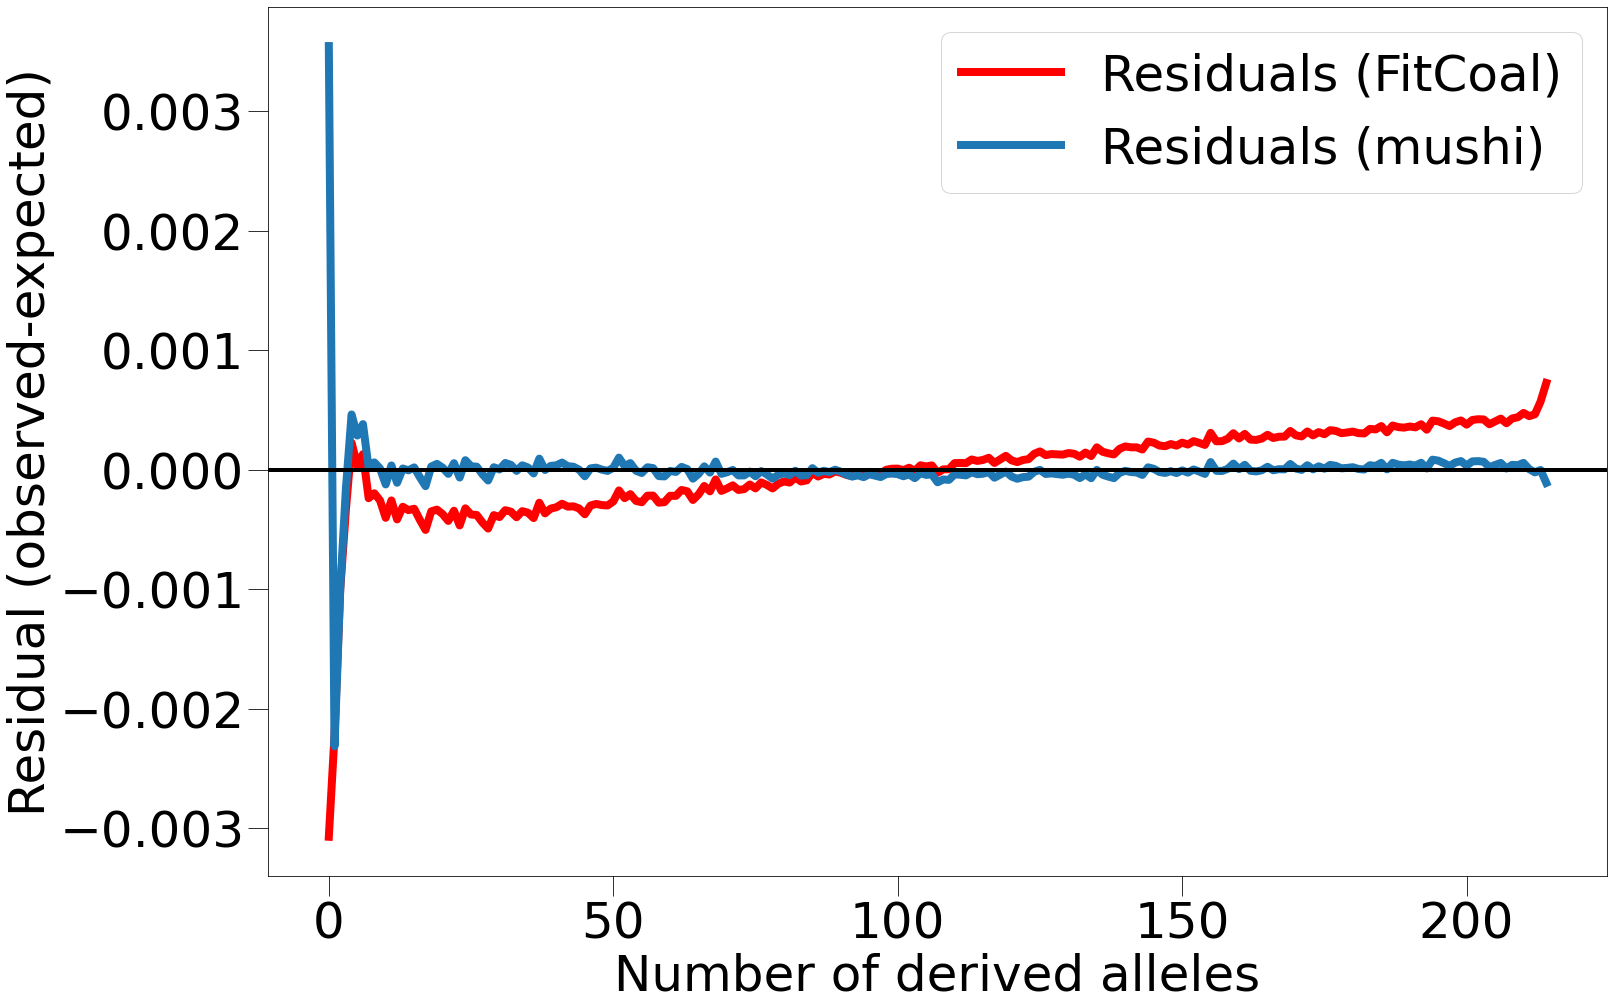

trend_1=0; trend_2=1; ridge=1000; truncate=1


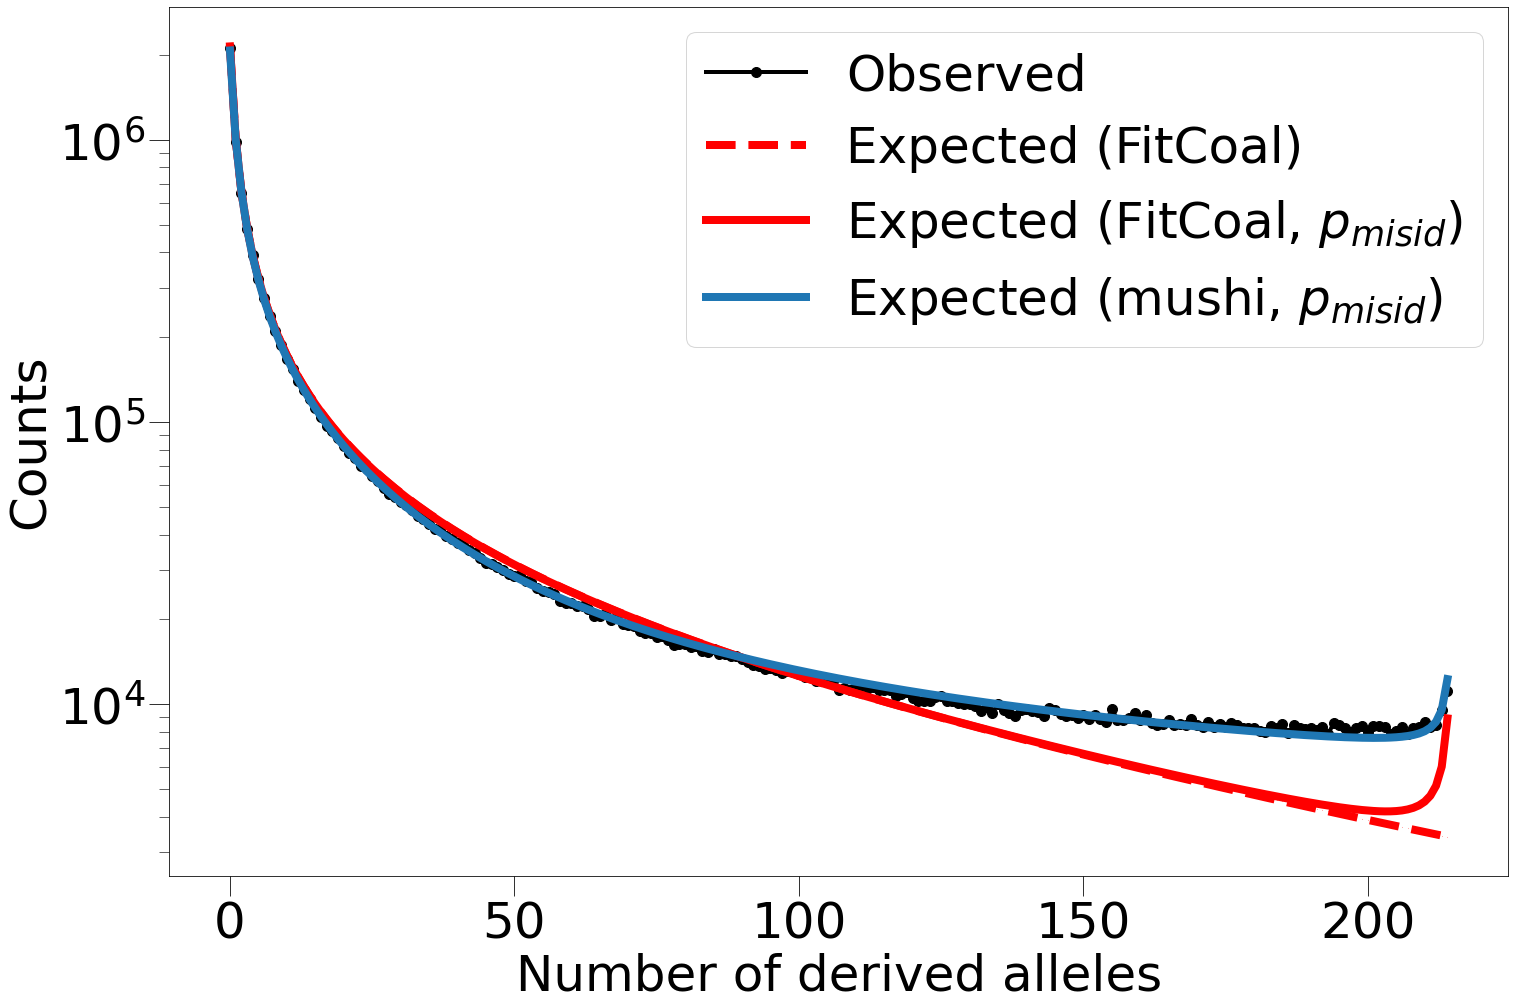

inferred p from mushi = 0.002570218954376807
FitCoal LL (without p_misid) -99867.21104141738
FitCoal LL (with p_misid) -77158.39417853218
mushi LL (with p_misid) = -1503.3365711546212
LL(mushi) - LL(FitCoal) (with p_misid in FitCoal) = 75655.05760737756
LL(mushi) - LL(FitCoal) (without p_misid)= 98363.87447026276





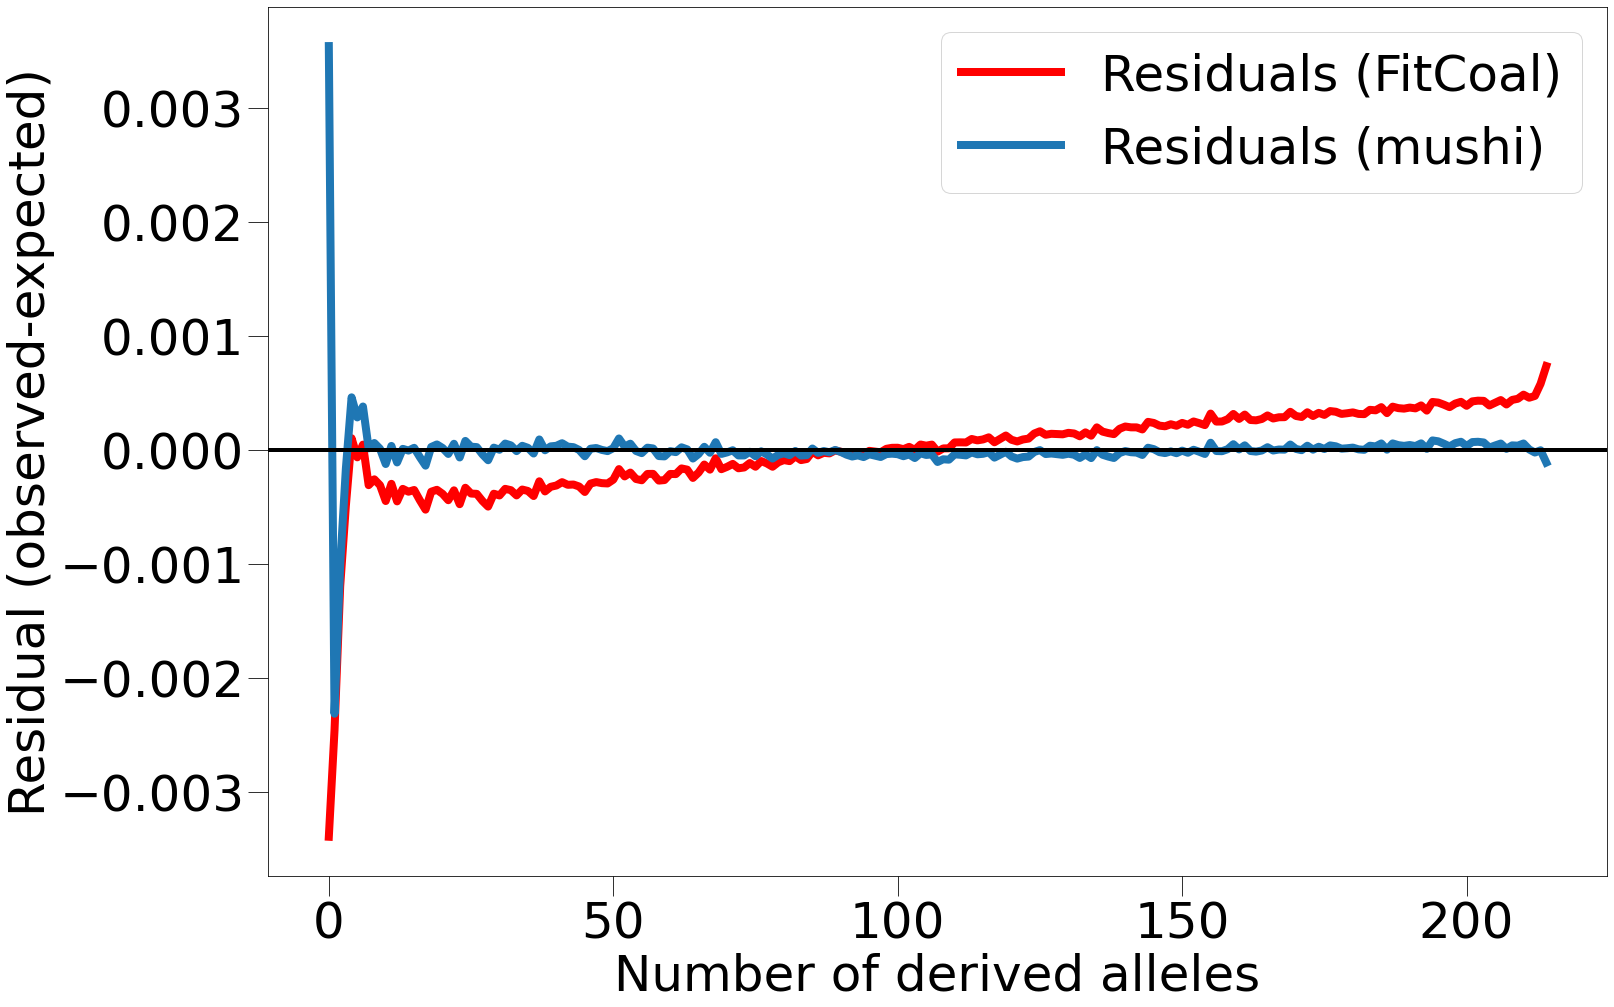

In [71]:
FitCoal_gen = 29 # the gen I used in FitCoal
mushi_gen = 30 # the gen I used in mushi
gen = 30 # the gen I use here

# trend_1s = [2,0]
# trend_2s = [1,10,100,1000]
# ridges = [100,750,1000,5000]
trend_1s = [0]
trend_2s = [1]
ridges = [1000]

zlinewidth = 8

folded = 'False'
zmarkersize = 0.1
zalpha=1
for trend_1 in trend_1s:
    for trend_2 in trend_2s: 
        for ridge in ridges:
            for truncate in [20,1]:
                print(f'trend_1={trend_1}; trend_2={trend_2}; ridge={ridge}; truncate={truncate}')
                
                # load observed data SFS and plot it (black)
                pop='YRI'
                observed_SFSfile= f'/home/tc557/rds/rds-durbin-group-8b3VcZwY7rY/projects/human/1000Genomes_30X/phased_vcf/SFS_241003/processed_241011/nopolar_pop{zpop}_allchrs_ndxx.txt.gz'
                observed_sfs = np.loadtxt(observed_SFSfile)
                observed_sfs_one_to_nminusone = observed_sfs[1:-1]
                plt.plot(observed_sfs_one_to_nminusone,label="Observed",linewidth=4,markersize=10,marker='o',color="black")

                # load mushi's expected SFS under model
                mushi_model_file = f'/home/tc557/rds/hpc-work/mushi_1KGP_inference_241011/{zpop}_{trend_1}_{trend_2}_{ridge}_{folded}model_parameters.pickle'
                with open(mushi_model_file,'rb') as f:
                    mushi_model_params = pickle.load(f)
                mushi_p = mushi_model_params['ancestral_state_misidentification_rate']
                ancestral_state_misidentification_rate = mushi_p
                _observed_data = mushi_model_params['observed_SFS']
                mushi_expected_SFS = mushi_model_params['expected_sfs']
                mushi_expected_SFS_norm = mushi_expected_SFS/mushi_expected_SFS.sum()

                # load FitCoal inferred model
                inferencefile = f'/home/tc557/FitCoal1dot0/inference1KGP_241011_mydata_nopolar_mappability_Bval0.8/truncate{truncate}_{zpop}.txt'
                inference = np.loadtxt(inferencefile,skiprows=1)
                inference[:,0] = gen*inference[:,0]/FitCoal_gen
                FitCoal_timepoints = clean_time_column_from_FitCoal(inference[0:-1,0])
                expected_SFS_from_FitCoal_calculatedbymushi = compute_expected_sfs(len(observed_sfs)-1, FitCoal_timepoints/gen, inference[:,1]) # get the expected SFS from FitCoal's model, using mushi's function
                expected_SFS_from_FitCoal_calculatedbymushi_norm = expected_SFS_from_FitCoal_calculatedbymushi/expected_SFS_from_FitCoal_calculatedbymushi.sum()
                expected_SFS_from_FitCoal_calculatedbymushi_norm_ancmisid = (1-ancestral_state_misidentification_rate)*expected_SFS_from_FitCoal_calculatedbymushi_norm+ancestral_state_misidentification_rate*expected_SFS_from_FitCoal_calculatedbymushi_norm[::-1]

                # plot expected SFS from FitCoal's model, with and without p_misid
                plt.plot(expected_SFS_from_FitCoal_calculatedbymushi_norm*observed_sfs_one_to_nminusone.sum(),label="Expected (FitCoal)",color="red",marker='v',markersize=zmarkersize,linewidth=zlinewidth,linestyle="dashed",alpha=zalpha)
                plt.plot(expected_SFS_from_FitCoal_calculatedbymushi_norm_ancmisid*observed_sfs_one_to_nminusone.sum(),label="Expected (FitCoal, $p_{misid}$)",color="red",marker='o',markersize=zmarkersize,linewidth=zlinewidth,alpha=zalpha)
                
                plt.yscale('log')
                plt.xlabel('Number of derived alleles')
                plt.ylabel('Counts')
                plt.tick_params(which='major',length=20)
                plt.tick_params(which='minor',length=10)
                # plt.xscale('log')
                # plt.plot(_observed_data,label="Observed (check)",linewidth=4,linestyle="dashed")
                plt.plot(mushi_expected_SFS,label="Expected (mushi, $p_{misid}$)",color="#1f77b4",linewidth=zlinewidth,markersize=zmarkersize,marker='o',alpha=zalpha)
                plt.legend()
            #     plt.savefig(f'/home/tc557/falsifying_bottleneck/Figures_241008/paperFigure_FitCoal_mushi_YRI_SFS_241007_1230.pdf')
                plt.savefig(f'/home/tc557/falsifying_bottleneck/Figures_241008/paperFigure_FitCoal_truncate{truncate}_mushi{trend_1}_{trend_2}_{ridge}_YRI_SFS_241014_1900.pdf')
            
                plt.show()

                print(f'inferred p from mushi = {ancestral_state_misidentification_rate}')
                LL_FitCoal_without = log_likelihood_poisson(observed_sfs_one_to_nminusone,expected_SFS_from_FitCoal_calculatedbymushi_norm)
                print(f'FitCoal LL (without p_misid) {LL_FitCoal_without}')

                LL_FitCoal_with = log_likelihood_poisson(observed_sfs_one_to_nminusone,expected_SFS_from_FitCoal_calculatedbymushi_norm_ancmisid)
                print(f'FitCoal LL (with p_misid) {LL_FitCoal_with}')                

                LL_mushi = log_likelihood_poisson(observed_sfs_one_to_nminusone,mushi_expected_SFS_norm)
                print(f'mushi LL (with p_misid) = {LL_mushi}')

                LL_diffs_pmisid = LL_mushi-LL_FitCoal_with
                print(f'LL(mushi) - LL(FitCoal) (with p_misid in FitCoal) = {LL_diffs_pmisid}')

                LL_diffs = LL_mushi-LL_FitCoal_without
                print(f'LL(mushi) - LL(FitCoal) (without p_misid)= {LL_diffs}')
                
                print(f'\n\n')

                observed_sfs_one_to_nminusone_norm = observed_sfs_one_to_nminusone/observed_sfs_one_to_nminusone.sum()
                residuals_FitCoal = observed_sfs_one_to_nminusone_norm - expected_SFS_from_FitCoal_calculatedbymushi_norm
                residuals_mushi = observed_sfs_one_to_nminusone_norm - mushi_expected_SFS_norm
                plt.plot(residuals_FitCoal,label="Residuals (FitCoal)",linewidth=zlinewidth,color="red")
                plt.plot(residuals_mushi,label="Residuals (mushi)",linewidth=zlinewidth,color="#1f77b4")
                plt.axhline(0,color="black",linewidth=4)
                plt.xlabel('Number of derived alleles')
                plt.ylabel('Residual (observed-expected)')
                plt.tick_params(which='major',length=20)
                plt.tick_params(which='minor',length=10)

                plt.legend()
                plt.show()


trend_1=0; trend_2=1; ridge=1000; truncate=20


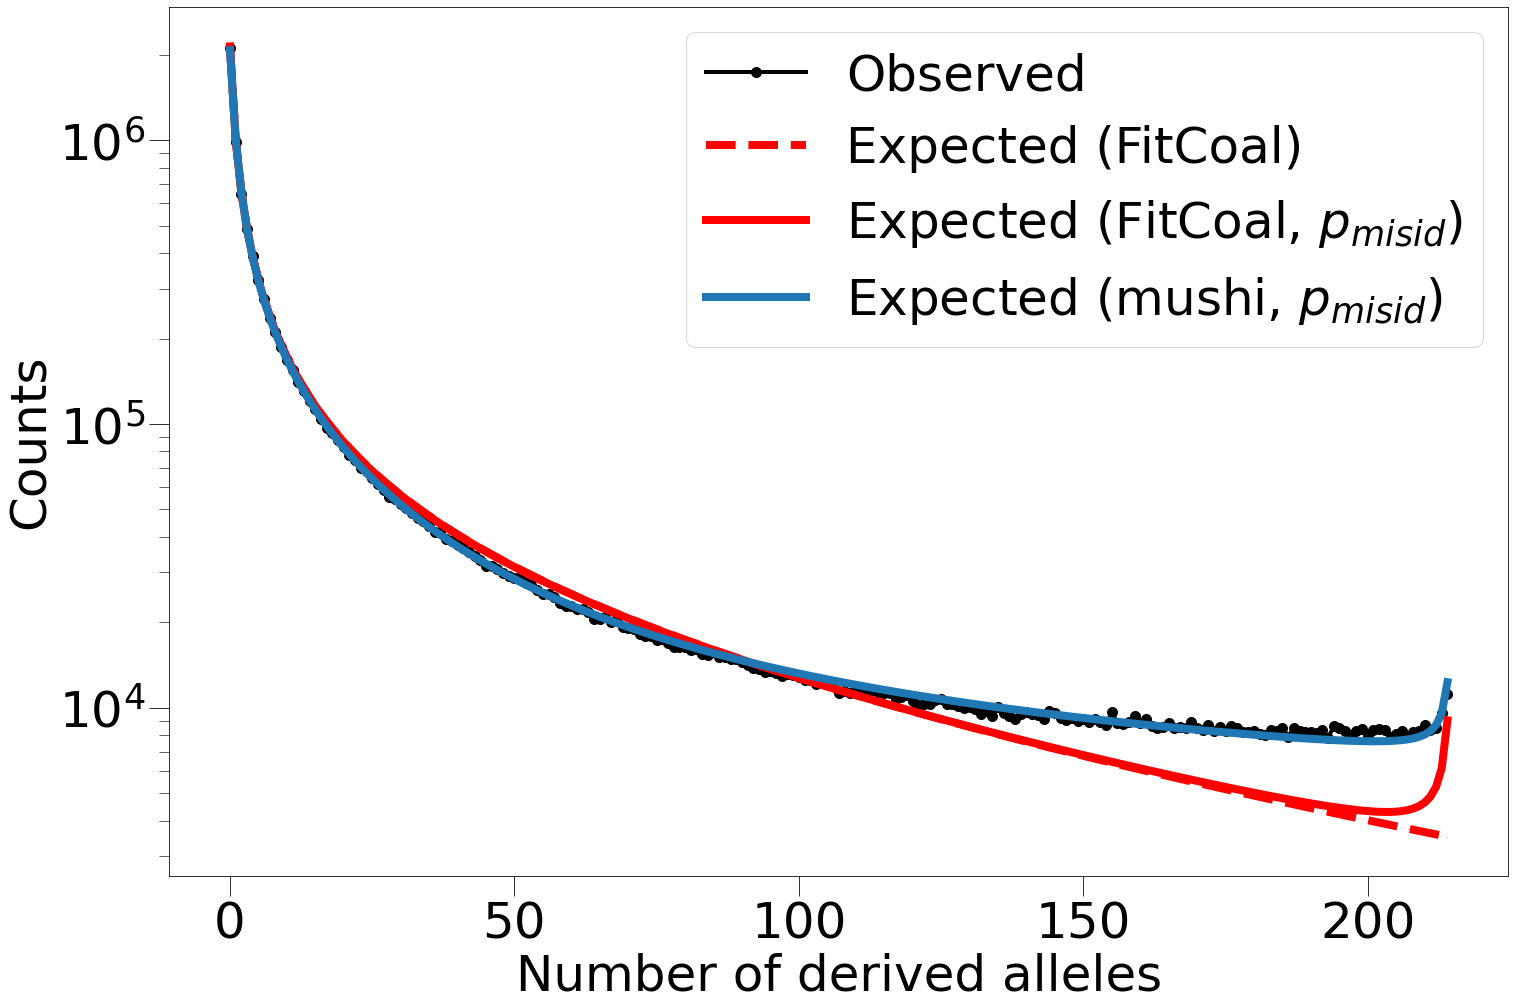

inferred p from mushi = 0.002570218954376807
FitCoal LL (without p_misid) -92936.9867075761
FitCoal LL (with p_misid) -71406.77875781387
mushi LL (with p_misid) = -1503.3365711546212
LL(mushi) - LL(FitCoal) (with p_misid in FitCoal) = 69903.44218665925
LL(mushi) - LL(FitCoal) (without p_misid)= 91433.65013642148





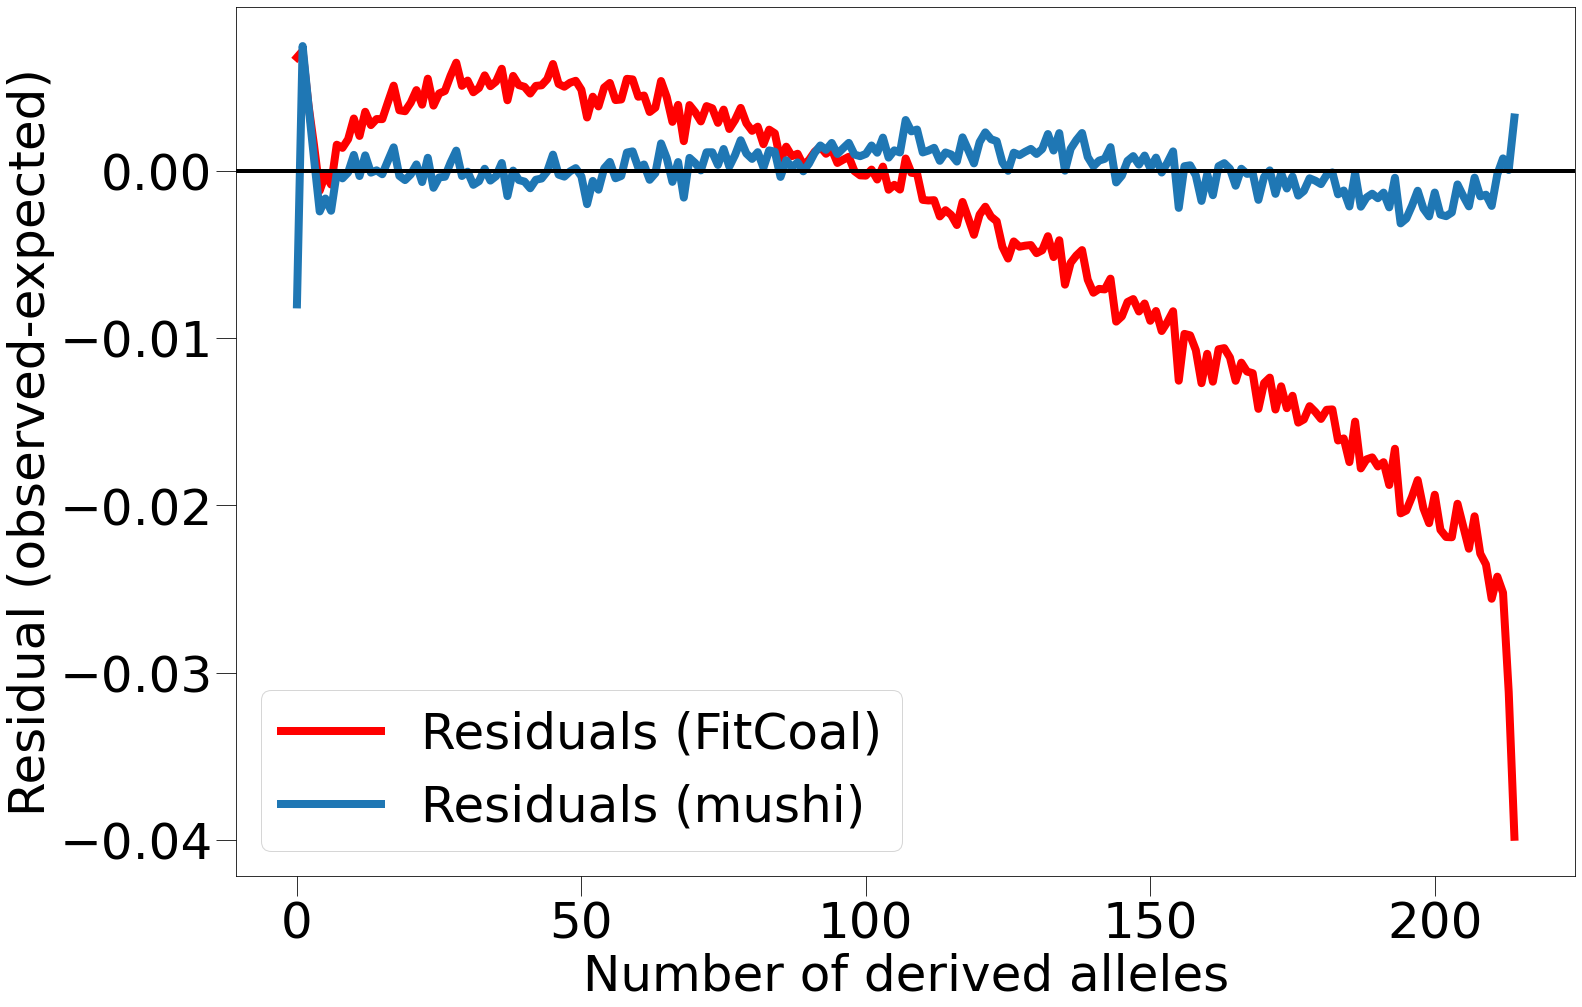

trend_1=0; trend_2=1; ridge=1000; truncate=1


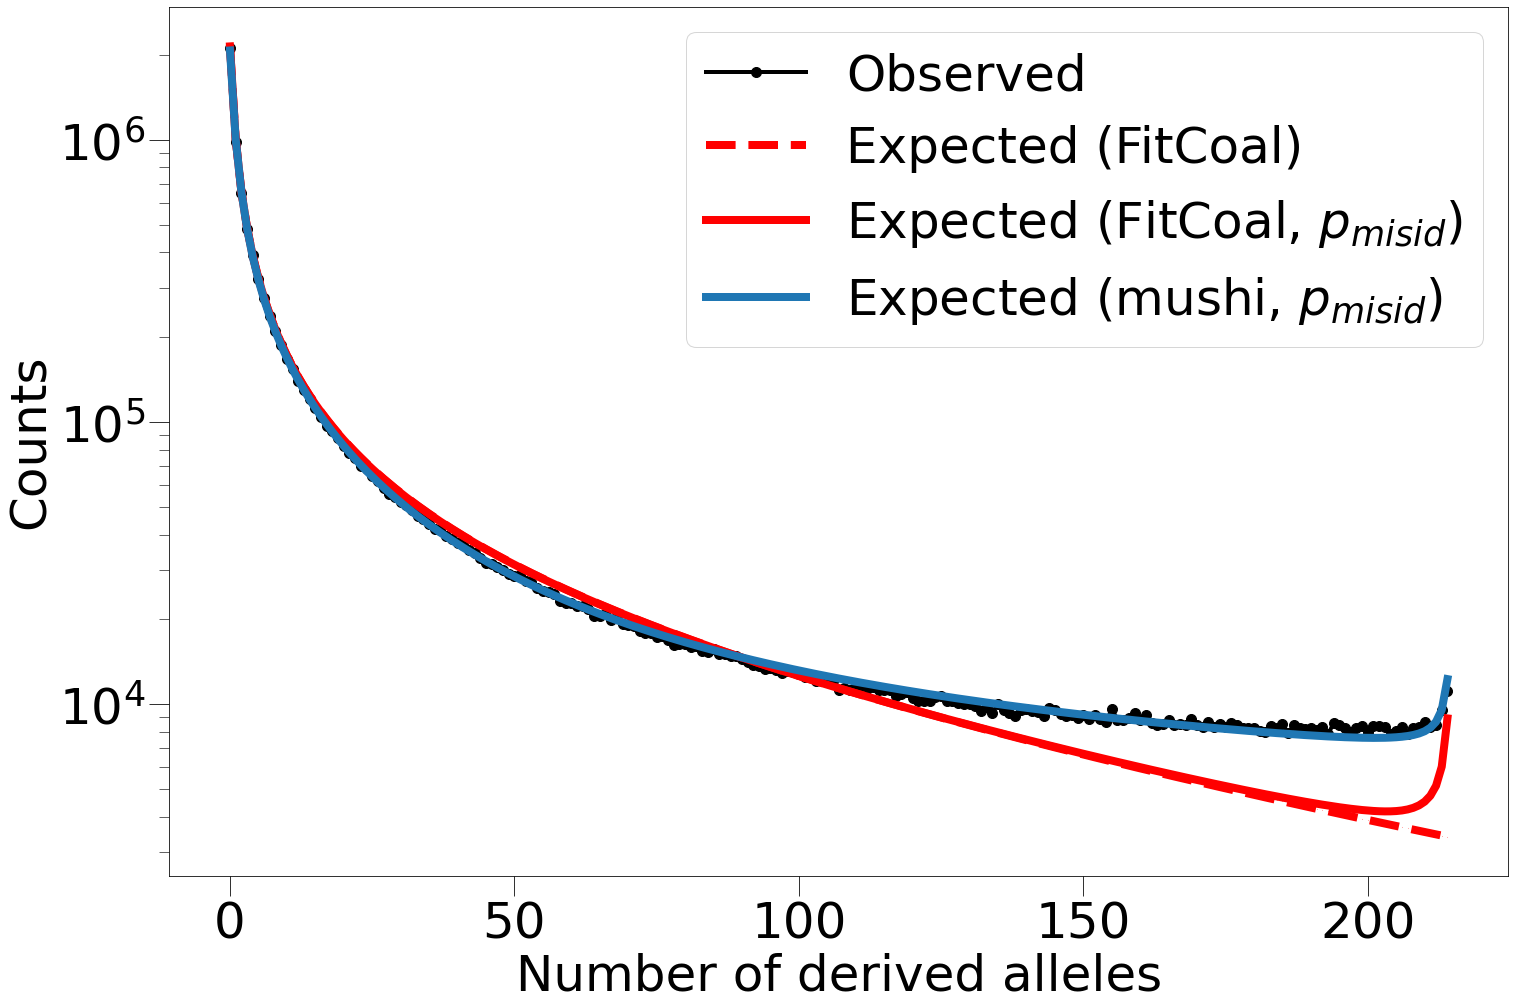

inferred p from mushi = 0.002570218954376807
FitCoal LL (without p_misid) -99867.21104141738
FitCoal LL (with p_misid) -77158.39417853218
mushi LL (with p_misid) = -1503.3365711546212
LL(mushi) - LL(FitCoal) (with p_misid in FitCoal) = 75655.05760737756
LL(mushi) - LL(FitCoal) (without p_misid)= 98363.87447026276





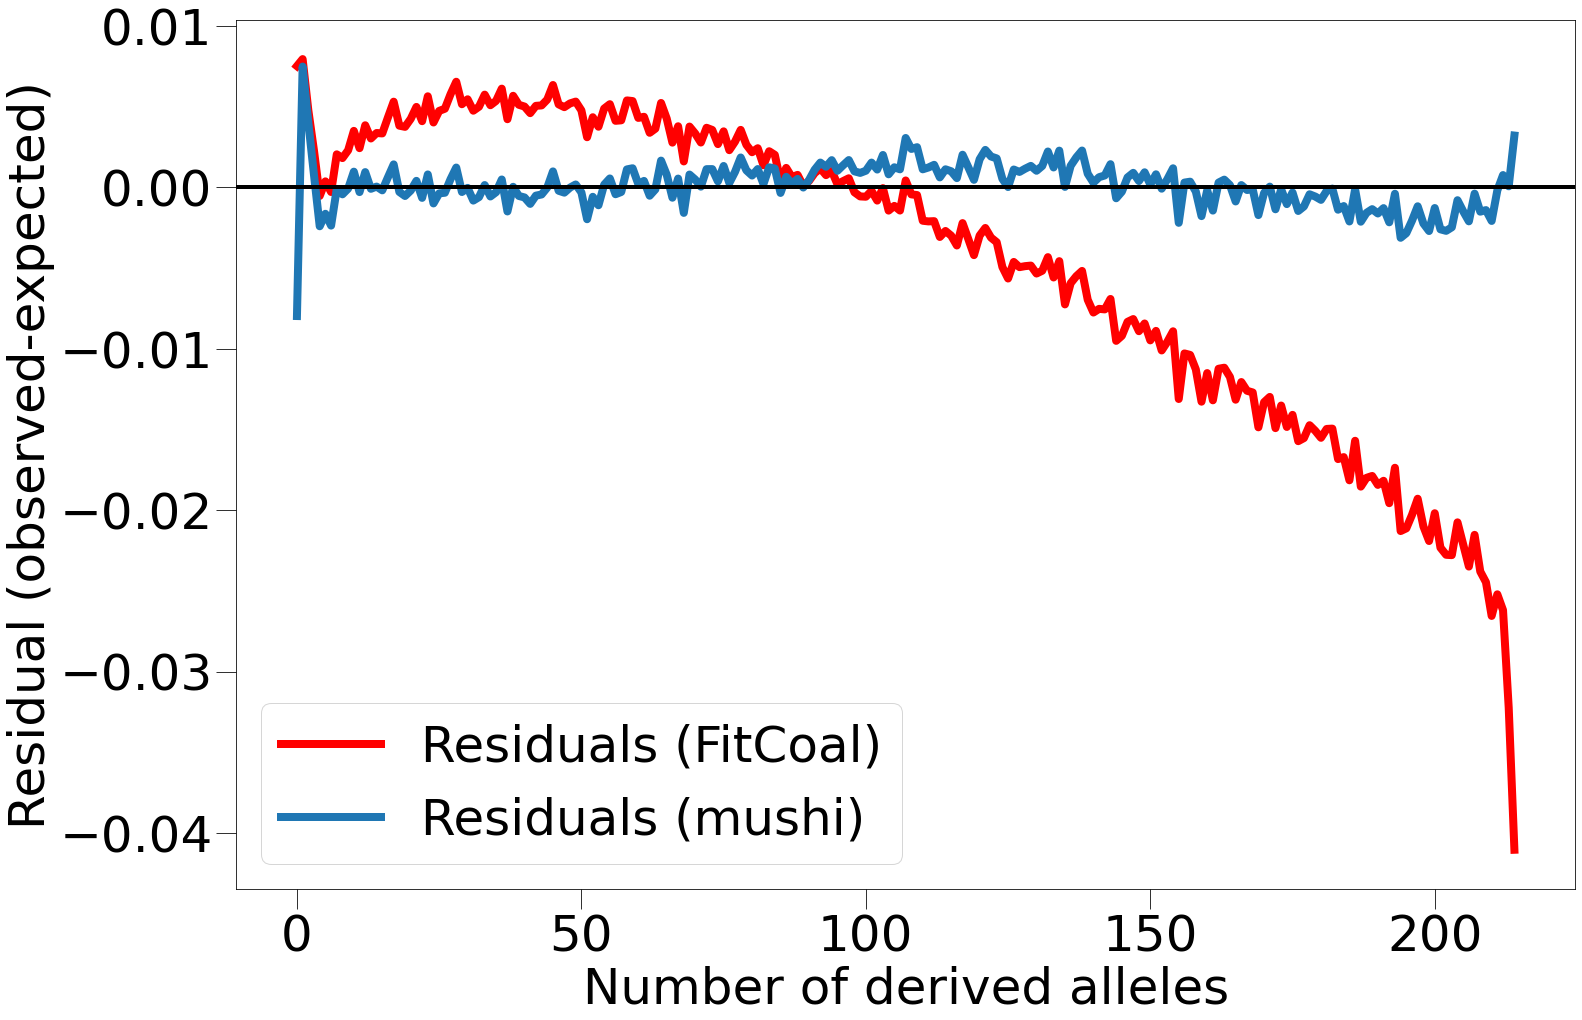

In [50]:
FitCoal_gen = 29 # the gen I used in FitCoal
mushi_gen = 30 # the gen I used in mushi
gen = 30 # the gen I use here

# trend_1s = [2,0]
# trend_2s = [1,10,100,1000]
# ridges = [100,750,1000,5000]
trend_1s = [0]
trend_2s = [1]
ridges = [1000]

zlinewidth = 8

folded = 'False'
zmarkersize = 0.1
zalpha=1
for trend_1 in trend_1s:
    for trend_2 in trend_2s: 
        for ridge in ridges:
            for truncate in [20,1]:
                print(f'trend_1={trend_1}; trend_2={trend_2}; ridge={ridge}; truncate={truncate}')
                
                # load observed data SFS and plot it (black)
                pop='YRI'
                observed_SFSfile= f'/home/tc557/rds/rds-durbin-group-8b3VcZwY7rY/projects/human/1000Genomes_30X/phased_vcf/SFS_241003/processed_241011/nopolar_pop{zpop}_allchrs_ndxx.txt.gz'
                observed_sfs = np.loadtxt(observed_SFSfile)
                observed_sfs_one_to_nminusone = observed_sfs[1:-1]
                plt.plot(observed_sfs_one_to_nminusone,label="Observed",linewidth=4,markersize=10,marker='o',color="black")

                # load mushi's expected SFS under model
                mushi_model_file = f'/home/tc557/rds/hpc-work/mushi_1KGP_inference_241011/{zpop}_{trend_1}_{trend_2}_{ridge}_{folded}model_parameters.pickle'
                with open(mushi_model_file,'rb') as f:
                    mushi_model_params = pickle.load(f)
                mushi_p = mushi_model_params['ancestral_state_misidentification_rate']
                ancestral_state_misidentification_rate = mushi_p
                _observed_data = mushi_model_params['observed_SFS']
                mushi_expected_SFS = mushi_model_params['expected_sfs']
                mushi_expected_SFS_norm = mushi_expected_SFS/mushi_expected_SFS.sum()

                # load FitCoal inferred model
                inferencefile = f'/home/tc557/FitCoal1dot0/inference1KGP_241011_mydata_nopolar_mappability_Bval0.8/truncate{truncate}_{zpop}.txt'
                inference = np.loadtxt(inferencefile,skiprows=1)
                inference[:,0] = gen*inference[:,0]/FitCoal_gen
                FitCoal_timepoints = clean_time_column_from_FitCoal(inference[0:-1,0])
                expected_SFS_from_FitCoal_calculatedbymushi = compute_expected_sfs(len(observed_sfs)-1, FitCoal_timepoints/gen, inference[:,1]) # get the expected SFS from FitCoal's model, using mushi's function
                expected_SFS_from_FitCoal_calculatedbymushi_norm = expected_SFS_from_FitCoal_calculatedbymushi/expected_SFS_from_FitCoal_calculatedbymushi.sum()
                expected_SFS_from_FitCoal_calculatedbymushi_norm_ancmisid = (1-ancestral_state_misidentification_rate)*expected_SFS_from_FitCoal_calculatedbymushi_norm+ancestral_state_misidentification_rate*expected_SFS_from_FitCoal_calculatedbymushi_norm[::-1]

                # plot expected SFS from FitCoal's model, with and without p_misid
                plt.plot(expected_SFS_from_FitCoal_calculatedbymushi_norm*observed_sfs_one_to_nminusone.sum(),label="Expected (FitCoal)",color="red",marker='v',markersize=zmarkersize,linewidth=zlinewidth,linestyle="dashed",alpha=zalpha)
                plt.plot(expected_SFS_from_FitCoal_calculatedbymushi_norm_ancmisid*observed_sfs_one_to_nminusone.sum(),label="Expected (FitCoal, $p_{misid}$)",color="red",marker='o',markersize=zmarkersize,linewidth=zlinewidth,alpha=zalpha)
                
                plt.yscale('log')
                plt.xlabel('Number of derived alleles')
                plt.ylabel('Counts')
                plt.tick_params(which='major',length=20)
                plt.tick_params(which='minor',length=10)
                # plt.xscale('log')
                # plt.plot(_observed_data,label="Observed (check)",linewidth=4,linestyle="dashed")
                plt.plot(mushi_expected_SFS,label="Expected (mushi, $p_{misid}$)",color="#1f77b4",linewidth=zlinewidth,markersize=zmarkersize,marker='o',alpha=zalpha)
                plt.legend()
            #     plt.savefig(f'/home/tc557/falsifying_bottleneck/Figures_241008/paperFigure_FitCoal_mushi_YRI_SFS_241007_1230.pdf')
                plt.show()

                print(f'inferred p from mushi = {ancestral_state_misidentification_rate}')
                LL_FitCoal_without = log_likelihood_poisson(observed_sfs_one_to_nminusone,expected_SFS_from_FitCoal_calculatedbymushi_norm)
                print(f'FitCoal LL (without p_misid) {LL_FitCoal_without}')

                LL_FitCoal_with = log_likelihood_poisson(observed_sfs_one_to_nminusone,expected_SFS_from_FitCoal_calculatedbymushi_norm_ancmisid)
                print(f'FitCoal LL (with p_misid) {LL_FitCoal_with}')                

                LL_mushi = log_likelihood_poisson(observed_sfs_one_to_nminusone,mushi_expected_SFS_norm)
                print(f'mushi LL (with p_misid) = {LL_mushi}')

                LL_diffs_pmisid = LL_mushi-LL_FitCoal_with
                print(f'LL(mushi) - LL(FitCoal) (with p_misid in FitCoal) = {LL_diffs_pmisid}')

                LL_diffs = LL_mushi-LL_FitCoal_without
                print(f'LL(mushi) - LL(FitCoal) (without p_misid)= {LL_diffs}')
                
                print(f'\n\n')

                observed_sfs_one_to_nminusone_norm = observed_sfs_one_to_nminusone/observed_sfs_one_to_nminusone.sum()
                residuals_FitCoal = observed_sfs_one_to_nminusone_norm - expected_SFS_from_FitCoal_calculatedbymushi_norm
                residuals_mushi = observed_sfs_one_to_nminusone_norm - mushi_expected_SFS_norm
                residuals_FitCoal = (expected_SFS_from_FitCoal_calculatedbymushi_norm - observed_sfs_one_to_nminusone_norm)/np.sqrt(expected_SFS_from_FitCoal_calculatedbymushi_norm)
                residuals_mushi = (mushi_expected_SFS_norm-observed_sfs_one_to_nminusone_norm)/np.sqrt(mushi_expected_SFS_norm)
                plt.plot(residuals_FitCoal,label="Residuals (FitCoal)",linewidth=zlinewidth,color="red")
                plt.plot(residuals_mushi,label="Residuals (mushi)",linewidth=zlinewidth,color="#1f77b4")
                plt.axhline(0,color="black",linewidth=4)
                plt.xlabel('Number of derived alleles')
                plt.ylabel('Residual (observed-expected)')
                plt.tick_params(which='major',length=20)
                plt.tick_params(which='minor',length=10)

                plt.legend()
                plt.show()


# Simulating non-Africans to see if the OOA obscures the OOA bottleneck

In [51]:
onekgpops = os.listdir('/home/tc557/falsifying_bottleneck/Figs/Figure3A') # Hu et al inference
onekgpops = [i.split('.')[0] for i in onekgpops if 'slurm' not in i]
onekgpops_groups_colors = {'African':'red','European':'orange','East Asian':'blue','South Asian':'green','ME':'gold','American':'gold'}
pop_colors = {}
# European
pop_colors['GBR'] = onekgpops_groups_colors['European']
pop_colors['TSI'] = onekgpops_groups_colors['European']
pop_colors['IBS'] = onekgpops_groups_colors['European']
pop_colors['FIN'] = onekgpops_groups_colors['European']
pop_colors['CEU'] = onekgpops_groups_colors['European']


# South East and Central Asian
pop_colors['CHS'] = onekgpops_groups_colors['East Asian']
pop_colors['KHV'] = onekgpops_groups_colors['East Asian']
pop_colors['CHB'] = onekgpops_groups_colors['East Asian']
pop_colors['CDX'] = onekgpops_groups_colors['East Asian']
pop_colors['JPT'] = onekgpops_groups_colors['East Asian']

# South Asian 
pop_colors['BEB'] = onekgpops_groups_colors['South Asian']
pop_colors['PJL'] = onekgpops_groups_colors['South Asian']
pop_colors['GIH'] = onekgpops_groups_colors['South Asian']
pop_colors['STU'] = onekgpops_groups_colors['South Asian']
pop_colors['ITU'] = onekgpops_groups_colors['South Asian']

# South American
pop_colors['PUR'] = onekgpops_groups_colors['American']
pop_colors['CLM'] = onekgpops_groups_colors['American']
pop_colors['PEL'] = onekgpops_groups_colors['American']
pop_colors['MXL'] = onekgpops_groups_colors['American']

# African
pop_colors['ESN'] = onekgpops_groups_colors['African']
pop_colors['YRI'] = onekgpops_groups_colors['African']
pop_colors['MSL'] = onekgpops_groups_colors['African']
pop_colors['GWD'] = onekgpops_groups_colors['African']
pop_colors['ACB'] = onekgpops_groups_colors['African']
pop_colors['ASW'] = onekgpops_groups_colors['African']
pop_colors['LWK'] = onekgpops_groups_colors['African']

In [52]:
gen=30

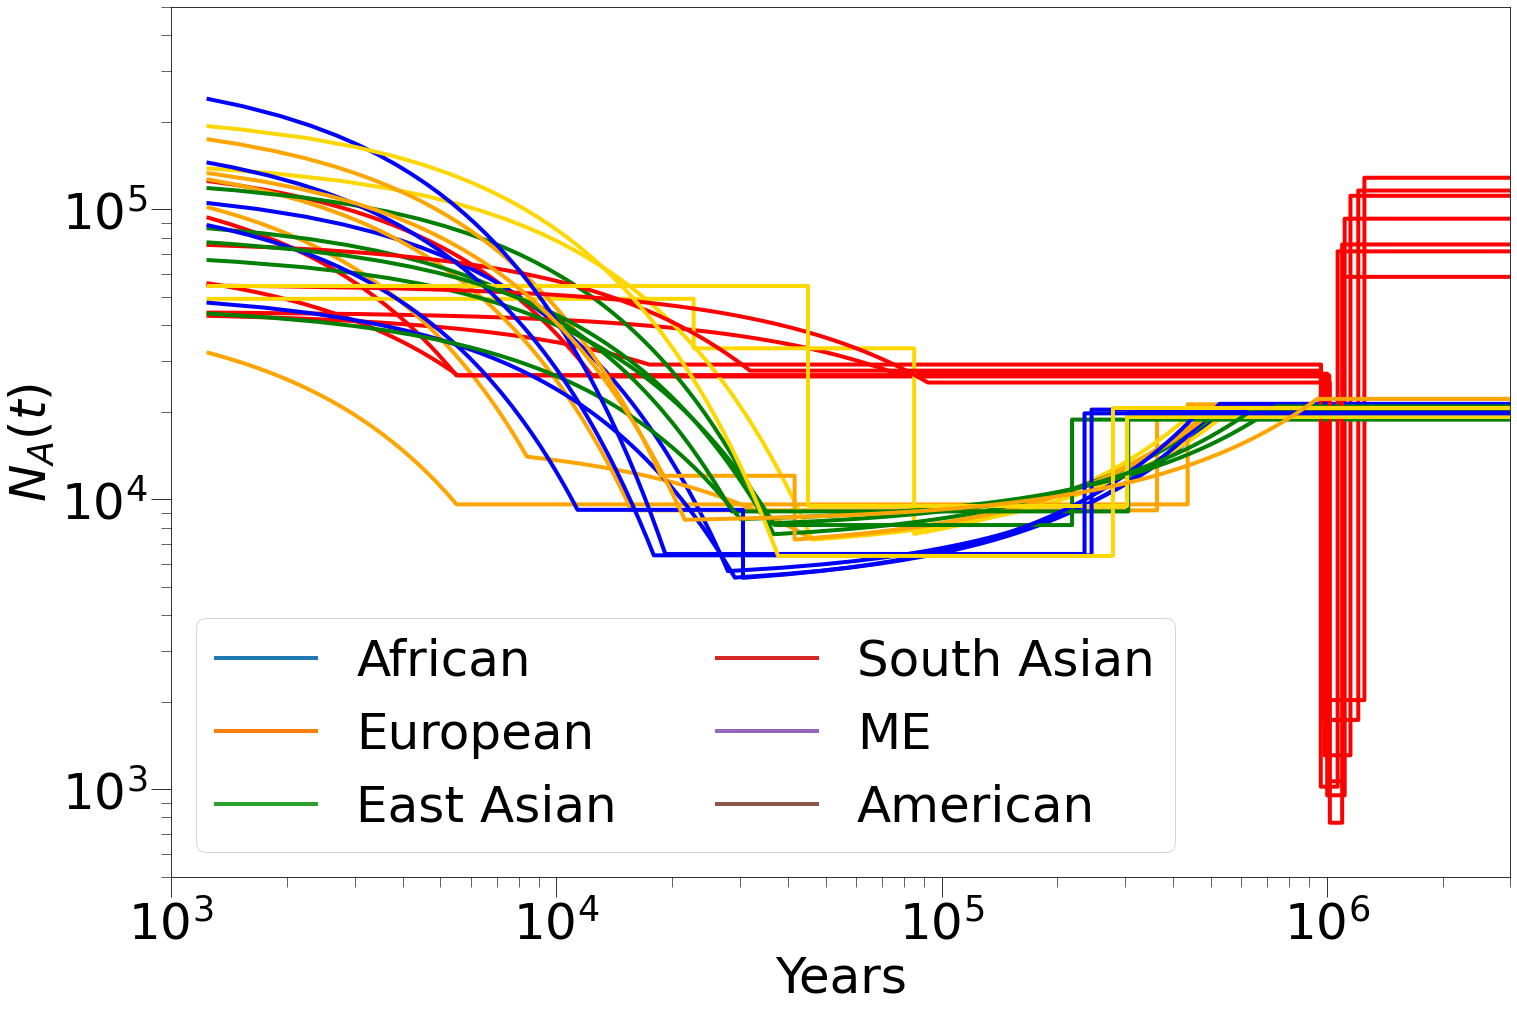

In [53]:
# reproduce plots

for zpop in onekgpops:
    filefromHu = f'/home/tc557/falsifying_bottleneck/Figs/Figure3A/{zpop}.txt'
    modelfromHu = np.loadtxt(filefromHu,skiprows=1)
    times_mygen = gen*modelfromHu[:,0]/24
    plt.plot(times_mygen,modelfromHu[:,1],linewidth=4,color=pop_colors[zpop])

for key in onekgpops_groups_colors.keys():
    plt.plot(range(1,3),range(1,3),label=key,linewidth=4)
plt.xscale('log')
plt.yscale('log')
plt.ylim(500,5e+05)
plt.xlim(1000,3e+06)
plt.xlabel('Years')
plt.ylabel('$N_A(t)$')
plt.tick_params(which='major',length=20)
plt.tick_params(which='minor',length=10)
plt.legend(loc="lower left",ncol=2,fontsize=50)


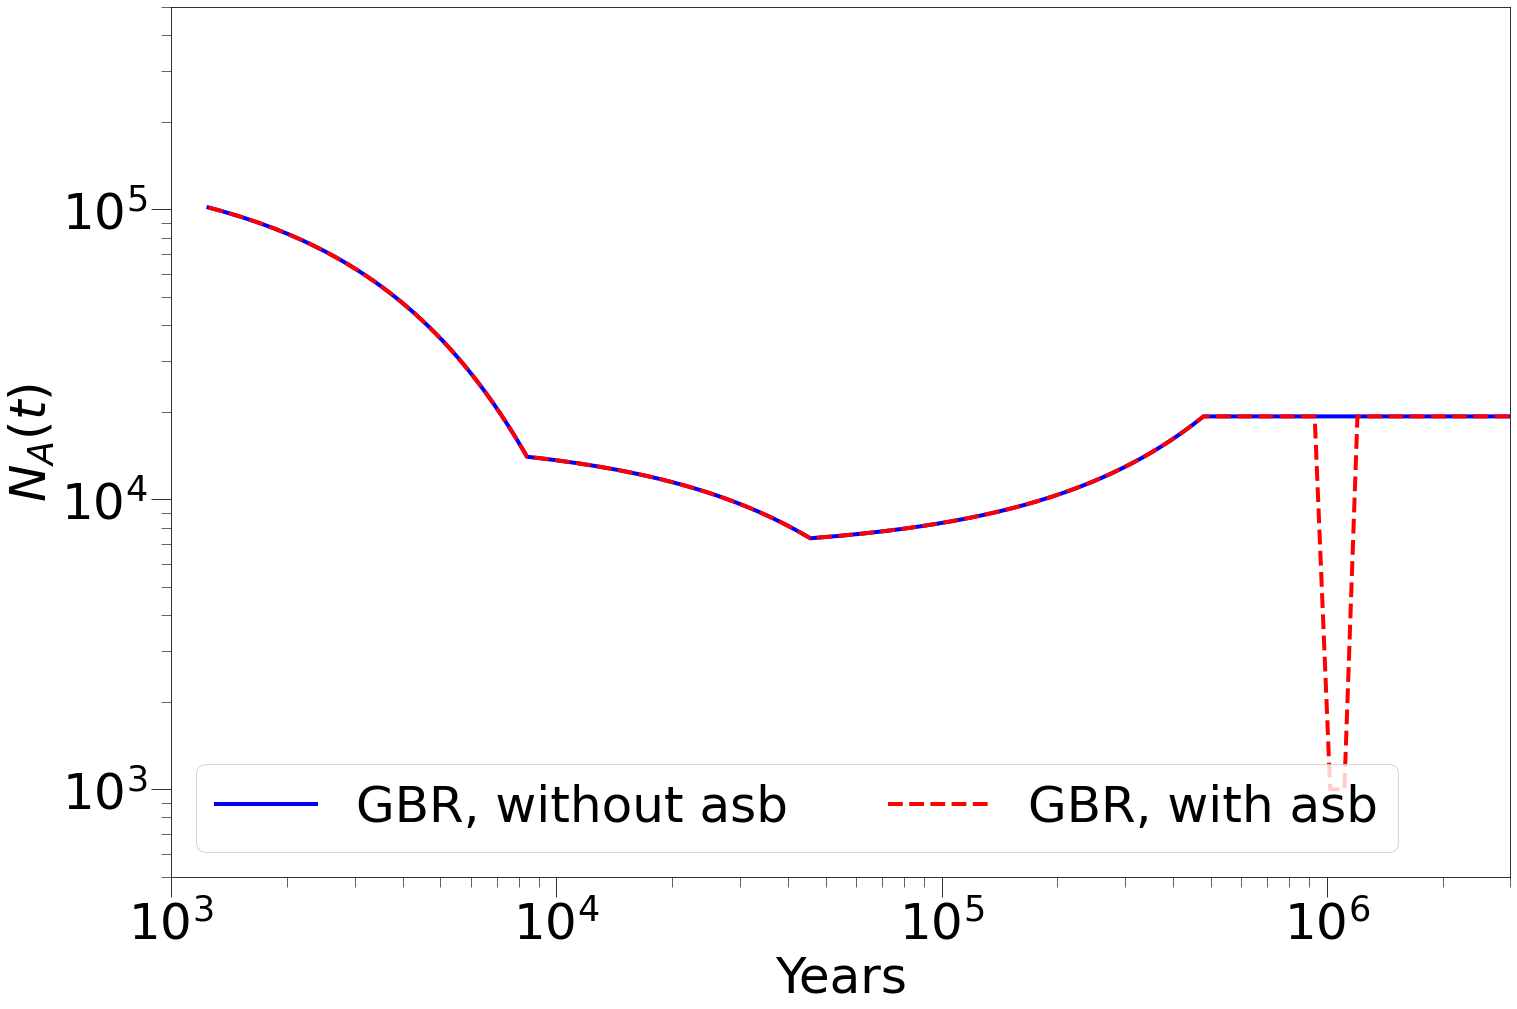

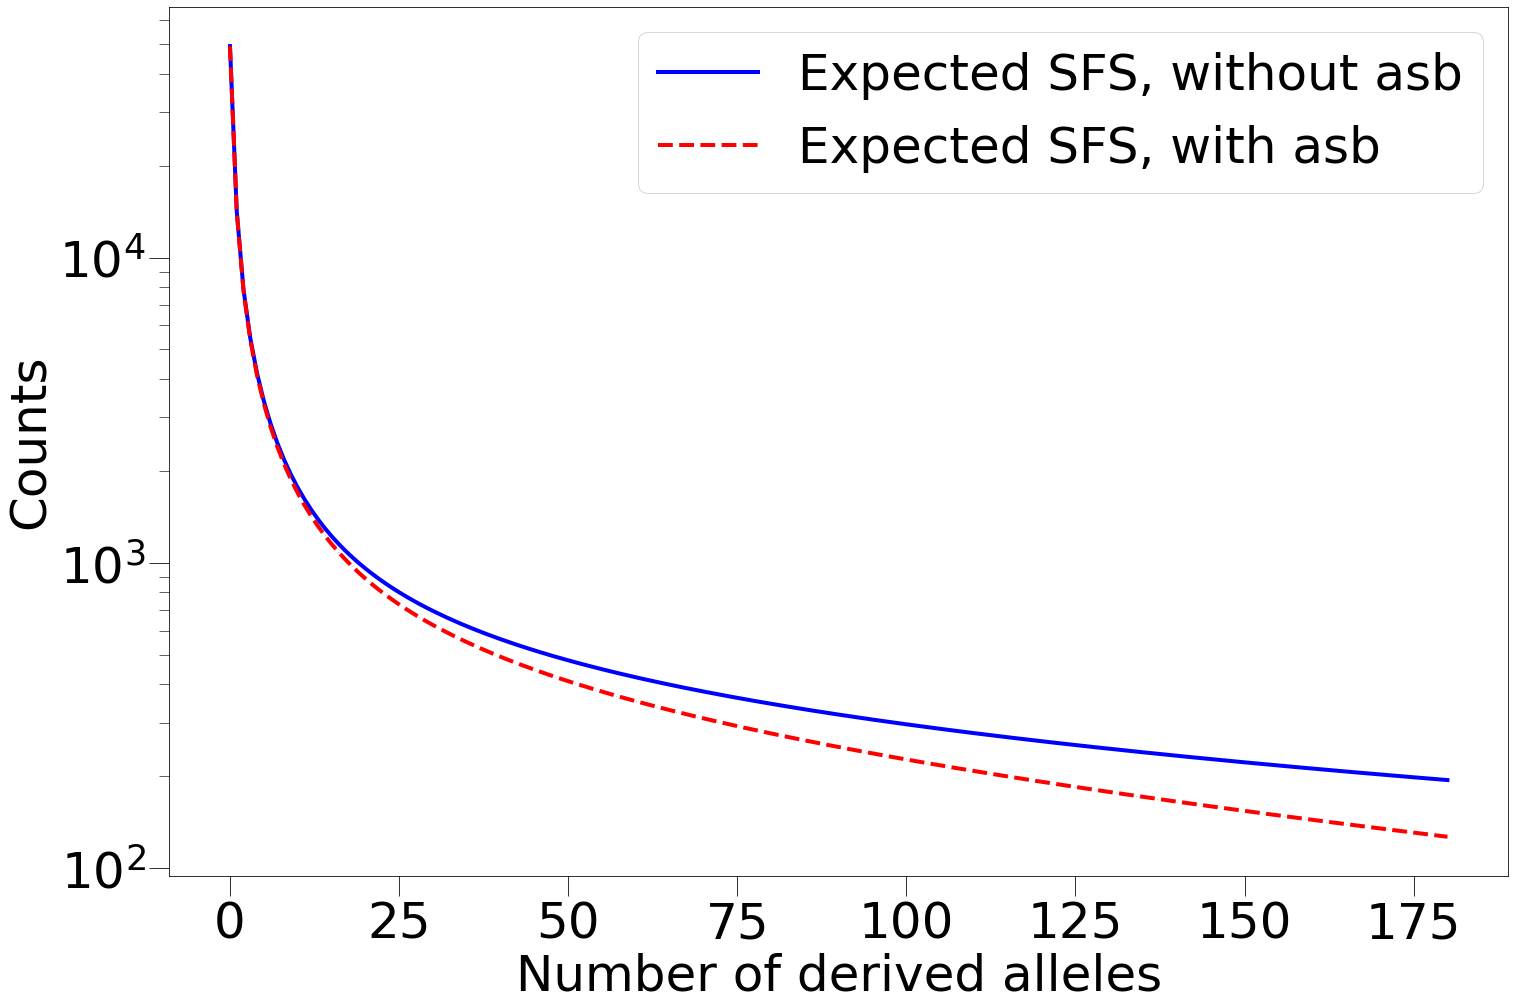

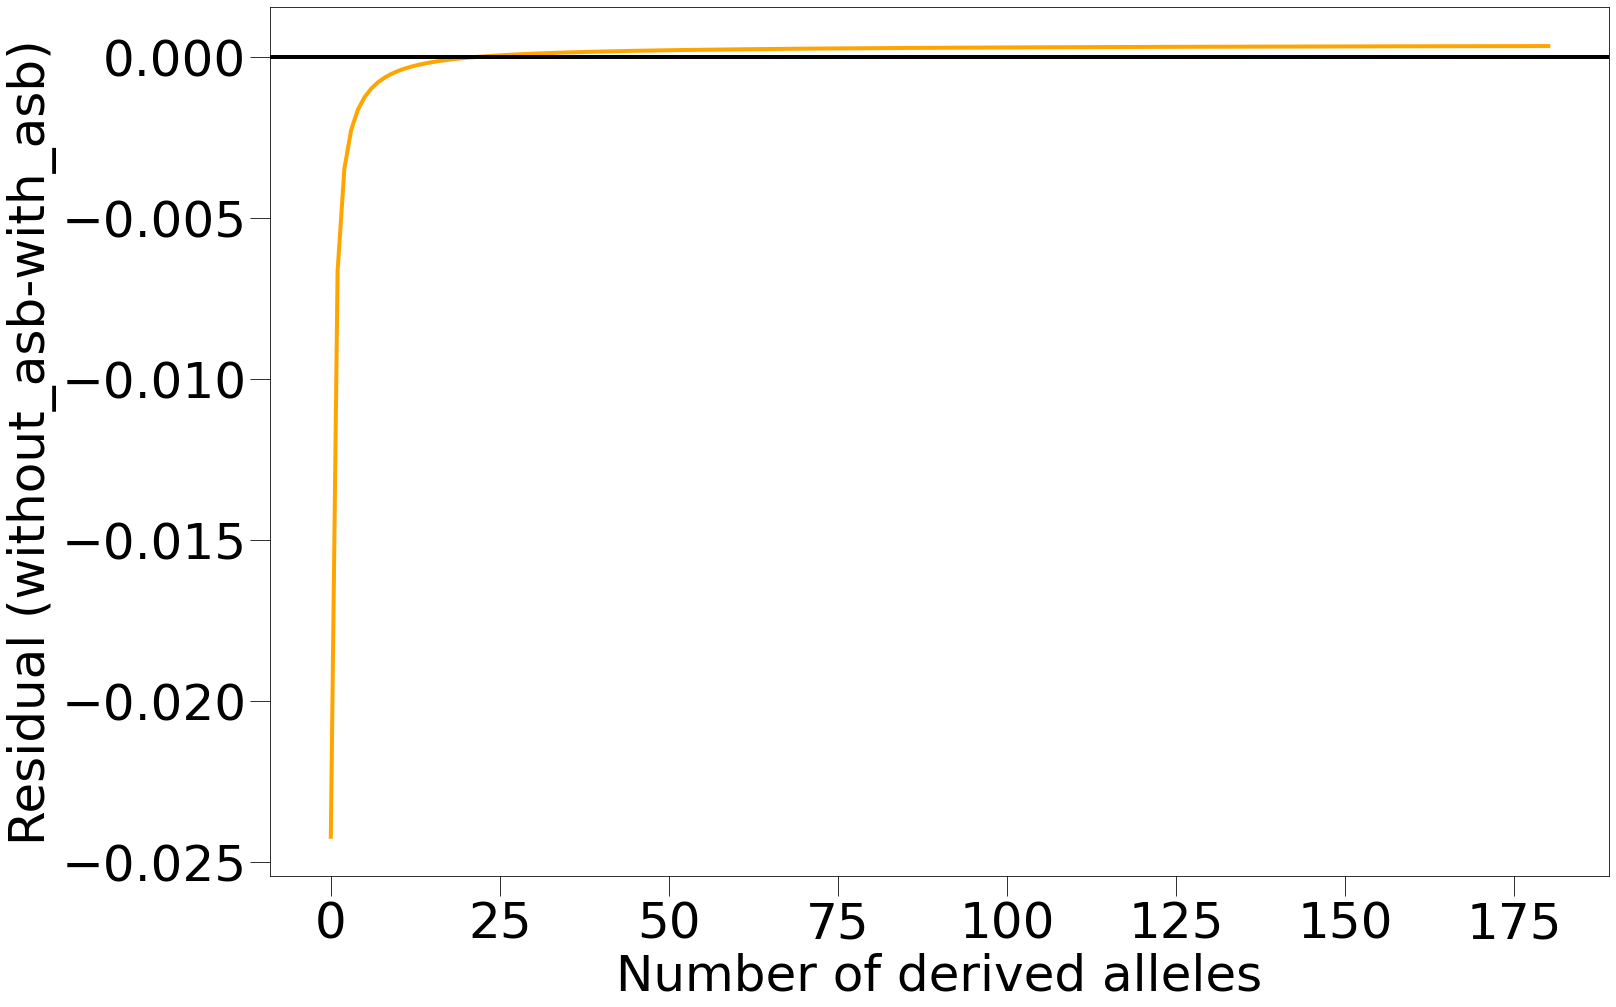

In [57]:
zpop="GBR"
filefromHu = f'/home/tc557/falsifying_bottleneck/Figs/Figure3A/{zpop}.txt'
modelfromHu = np.loadtxt(filefromHu,skiprows=1)
times_mygen = gen*modelfromHu[:,0]/24
bottleneck_start = 1e+06
bottleneck_end = 1.2e+06
sizes = np.copy(modelfromHu[:,1])
bottleneck_size = 1e+03
for c,time in enumerate(times_mygen):
    if time>=bottleneck_start and time<bottleneck_end:
        sizes[c] = bottleneck_size
        

plt.plot(times_mygen,modelfromHu[:,1],linewidth=4,label=f'{zpop}, without asb',color="blue")
plt.plot(times_mygen,sizes,linewidth=4,label=f'{zpop}, with asb',color="red",linestyle="dashed")

plt.xscale('log')
plt.yscale('log')
plt.ylim(500,5e+05)
plt.xlim(1000,3e+06)
plt.xlabel('Years')
plt.ylabel('$N_A(t)$')
plt.tick_params(which='major',length=20)
plt.tick_params(which='minor',length=10)
plt.legend(loc="lower left",ncol=2,fontsize=50)
plt.show()

SFSfile = f'/home/tc557/rds/rds-durbin-group-8b3VcZwY7rY/projects/human/1000Genomes_30X/phased_vcf/SFS_241003/processed_241003/refeqchimpgorilla_pop{zpop}_allchrs_ndxx.txt.gz'
observed_sfs = np.loadtxt(SFSfile)

times_mygen_clean = clean_time_column_from_FitCoal(times_mygen[0:-1])

expected_sans_asb = compute_expected_sfs(len(observed_sfs)-1, times_mygen_clean/gen, modelfromHu[:,1])
expected_with_asb = compute_expected_sfs(len(observed_sfs)-1, times_mygen_clean/gen, sizes)

expected_sans_asb_norm = expected_sans_asb/expected_sans_asb.sum()
expected_with_asb_norm = expected_with_asb/expected_with_asb.sum()
residuals = expected_sans_asb_norm-expected_with_asb_norm

plt.plot(expected_sans_asb,label="Expected SFS, without asb",color="blue",marker='v',markersize=zmarkersize,linewidth=4,alpha=zalpha)
plt.plot(expected_with_asb,label="Expected SFS, with asb",color="red",marker='o',markersize=zmarkersize,linewidth=4,linestyle="dashed",alpha=zalpha)
plt.yscale('log')
plt.xlabel('Number of derived alleles')
plt.ylabel('Counts')
plt.tick_params(which='major',length=20)
plt.tick_params(which='minor',length=10)
plt.legend()
plt.show()

plt.plot(residuals,color=pop_colors[zpop],linewidth=4)
plt.axhline(0,linewidth=4,color="black")
plt.xlabel('Number of derived alleles')
plt.ylabel('Residual (without_asb-with_asb)')
plt.tick_params(which='major',length=20)
plt.tick_params(which='minor',length=10)
plt.show()
